# Cyclicality Detection Demo
Looking at approaches for identifying cyclicalities in data, and optionally filtering them out.

## Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.fft import fft
from statsmodels.tsa.seasonal import STL

from matplotlib import pyplot as plt
%matplotlib inline

from cartwright.analysis import time_resolution #https://pypi.org/project/cartwright/

In [2]:
#download data if not present
import os
import requests
import urllib.request


# Covid daily case counts data
if not os.path.exists('owid-covid-data.csv'):
    url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
    r = requests.get(url, allow_redirects=True)
    with open('owid-covid-data.csv', 'wb') as f:
        f.write(r.content)

# NPM react library daily downloads
if not os.path.exists('npm_react_daily_downloads.json'):
    contents = urllib.request.urlopen("https://npm-stat.com/api/download-counts?package=react&from=2015-02-01&until=2023-01-09").read()
    with open('npm_react_daily_downloads.json', 'wb') as f:
        f.write(contents)


# tidal height data from kaggle (REQUIRES MANUAL DOWNLOAD)
if not os.path.exists('Tide Prediction.csv'):
    raise Exception('tide data not present. please download/extract dataset from https://www.kaggle.com/datasets/arjunbhaybhang/marine-institute-tide-prediction-dataset?select=Tide+Prediction.csv')


## US Covid Daily Case Counts Example

In [3]:
#open data file
df = pd.read_csv('owid-covid-data.csv')

#create new dataframe with just columns: "date", "new_cases", "new_deaths", where "location" is "United States"
us_data = df.loc[df['location'] == 'United States', ['date', 'new_cases', 'new_deaths']]

#replace any nans with 0
us_data = us_data.fillna(0)

In [4]:
us_data.head(25)

,date,new_cases,new_deaths
234443,2020-01-22,0.0,0.0
234444,2020-01-23,0.0,0.0
234445,2020-01-24,1.0,0.0
234446,2020-01-25,0.0,0.0
234447,2020-01-26,3.0,0.0
234448,2020-01-27,0.0,0.0
234449,2020-01-28,0.0,0.0
234450,2020-01-29,1.0,0.0
234451,2020-01-30,0.0,0.0
234452,2020-01-31,2.0,0.0


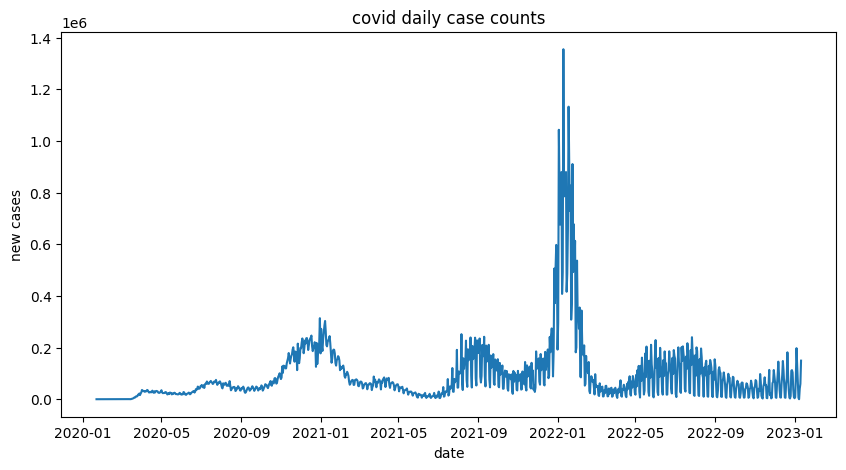

In [5]:
#get just the data for new cases as a numpy array
y = us_data['new_cases'].to_numpy()
dates = pd.to_datetime(us_data['date']).to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(dates, y)
plt.xlabel('date')
plt.ylabel('new cases')
plt.title('covid daily case counts')
plt.show()

## Use FFT to identify possible frequencies in the data

In [6]:
#identify a candidate frequency in the data
def get_candidate_frequency(y, prominence=1):
    norm_y = (y - np.mean(y)) / (np.max(y) - np.min(y)) * 2
    z = np.abs(fft(norm_y))
    freqs = np.fft.fftfreq(len(z))

    # find the peaks
    peaks, _ = find_peaks(z, prominence=prominence)

    diffs = np.diff(peaks)
    med = int(np.median(diffs))
    period = int(np.round(1/freqs[med]))

    print(f'possible cyclicality with period of {period} samples')
    plot_spectrum(z, freqs, peaks)
    
    return period

def plot_spectrum(z, freqs, peaks=None):
    plt.figure(figsize=(10,5))
    plt.plot(z)
    if peaks is not None:
        plt.plot(peaks, z[peaks], "ro")
    plt.title('Spectrum')
    plt.xlabel('frequency (cycles per whole duration of data)')
    plt.ylabel('magnitude')
    plt.show()
    

possible cyclicality with period of 7 samples


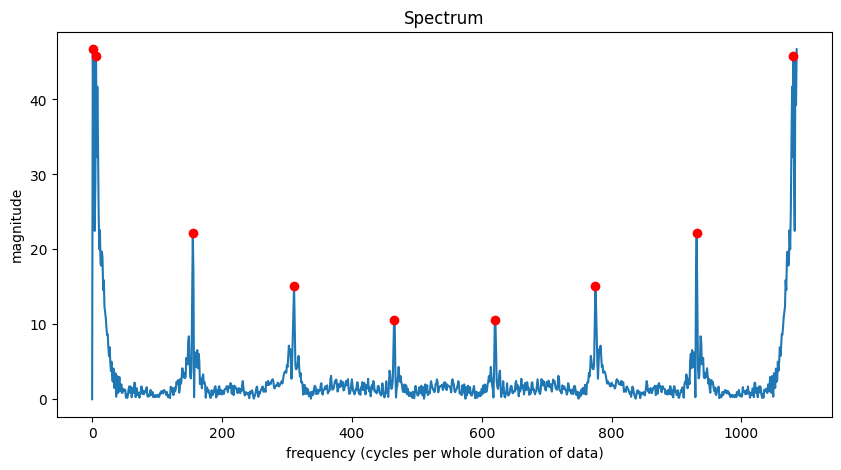

In [7]:
# period = get_candidate_frequency(y, prominence=1) # find_peak defaults are bad!
period = get_candidate_frequency(y, prominence=10)

In [8]:
# for this example, print out internals of the frequency detection process

y = us_data['new_cases'].to_numpy()
norm_y = (y - np.mean(y)) / (np.max(y) - np.min(y)) * 2
z = np.abs(fft(norm_y))
freqs = np.fft.fftfreq(len(z))

# find the peaks
peaks, _ = find_peaks(z, prominence=10)

diffs = np.diff(peaks)
med = int(np.median(diffs))
period = int(np.round(1/freqs[med]))

length = z.shape[0]
week_peak = peaks[2] #peak that corresponds to 7 day cycle
print('data length:                    ', length, '(samples)')
print('peaks:                          ', peaks)
print('peak spacing (diffs):           ', np.diff(peaks))
print('frequencies (cycles per sample):', np.array2string(peaks/z.shape[0], 120,2))
print('periods (samples per cycle):    ', np.array2string(z.shape[0]/peaks, 120,2))
print(f'{length}/{week_peak} = {length/week_peak} (days per cycle)')

data length:                     1086 (samples)
peaks:                           [   1    6  155  311  465  621  775  931 1080]
peak spacing (diffs):            [  5 149 156 154 156 154 156 149]
frequencies (cycles per sample): [9.21e-04 5.52e-03 1.43e-01 2.86e-01 4.28e-01 5.72e-01 7.14e-01 8.57e-01 9.94e-01]
periods (samples per cycle):     [1.09e+03 1.81e+02 7.01e+00 3.49e+00 2.34e+00 1.75e+00 1.40e+00 1.17e+00 1.01e+00]
1086/155 = 7.006451612903226 (days per cycle)


### Frequency analysis and interpreting the plot
#### How this works
All of the libraries for seasonal decomposition presume you already know the frequency of the cyclicality (e.g. daily, monthly, yearly, etc.). One approach for automatically identifing possible cyclicalities/frequencies in the data is to make use of the fourier transform (fft), which generates the spectrum of frequencies present in the data:
1. Take the FFT of the data to get a spectrum
2. find peaks in the spectrum
3. look for repeated spacing between the peaks, representing harmonics of a single frequency
4. the spacing then represents a found frequency in natual units
5. frequency is inverted to get period, and then rounded to the nearest integer (`statsmodels.STL` requires integer period)


#### Notes
- The X-axis is in natural units, which means frequencies are reported in terms of the entire duration of the data. For example, in the plot above we see a peak marked at `155`, which means a frequncy that oscillates 155 times during the entire duration of the data. Because the data was recorded as 1 sample per day, if we divide this by the total number of samples (`1086`), we get the daily frequency of `155/1086 = 0.142726 cycles per day`, or inverting to get period `1086/155 = 7.00645 days per cycle`
- The reason spacing between peaks is used, instead of directly converting peaks to frequencies is that it should be more robust. Looking at a spectrume, a weekly cyclicality will typically have a fundamental at 7 days, and then harmonics at 14 days, 21 days, 28 days ..., so the harmonics give you more certainty about the fundamental
- The plot is horizontally symmetric. This is related to the input to the fft being real-valued, while fft is a complex function. For this experiment, I keep both sides because it provides more data for measuring harmonic spacings

## Run Seasonal Decomposition

In [9]:
def seasonal_decomposition(y, period, y_label='y', x=None, x_label='x'):
    res = STL(y, period=period).fit()

    if x is None:
        x = np.arange(y.shape[0])
    
    #plot results
    fig, axes = plt.subplots(3, 1, sharex=True)
    fig.set_size_inches(10, 10)
    axes[0].plot(x,y)
    axes[0].set_ylabel(y_label)
    axes[1].plot(x,res.seasonal)
    axes[1].set_ylabel("Seasonal")
    axes[2].plot(x,res.trend+res.resid)
    axes[2].set_ylabel("Residual")
    plt.xlabel(x_label)

    plt.show()
    
    return res.trend, res.seasonal, res.resid


def multiseasonal_decomposition(y, periods, y_label='y'):
    for p in periods:
        trend, season, residual = seasonal_decomposition(y, p, y_label)
        y = trend + residual
        
    return trend, season, residual

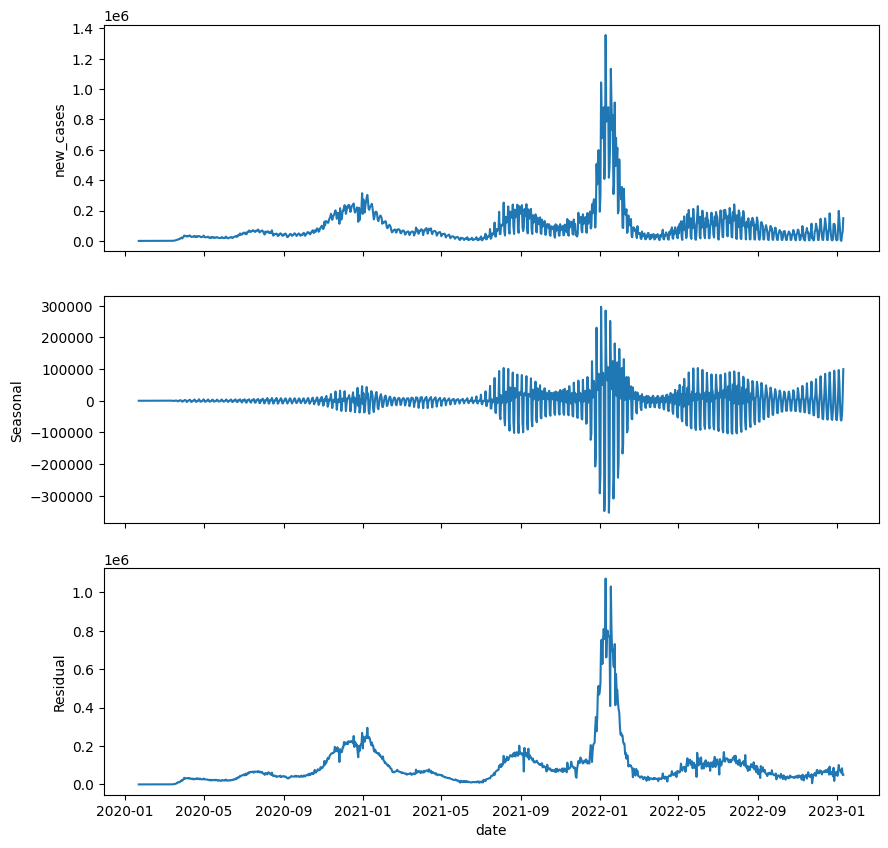

In [10]:
_ = seasonal_decomposition(y, period,'new_cases', dates, 'date')

## NPM Library Downloads Example

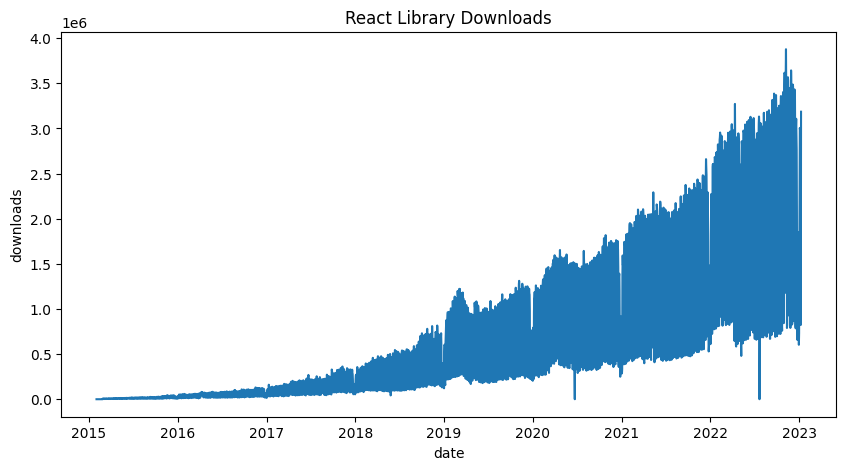

In [11]:
import json
with open('npm_react_daily_downloads.json') as f:
    npm_data = json.load(f)

counts = np.array([count for day,count in npm_data['react'].items()])
dates = pd.to_datetime([day for day,count in npm_data['react'].items()]).to_numpy()

plt.figure(figsize=(10, 5))
plt.plot(dates, counts)
plt.xlabel('date')
plt.ylabel('downloads')
plt.title('React Library Downloads')
plt.show()

possible cyclicality with period of 7 samples


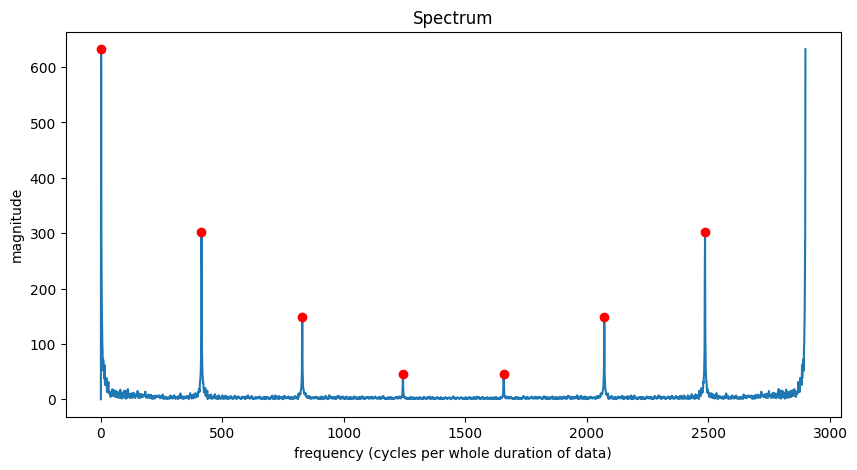

In [12]:
# period = get_candidate_frequency(counts, prominence=10)
period = get_candidate_frequency(counts, prominence=25)

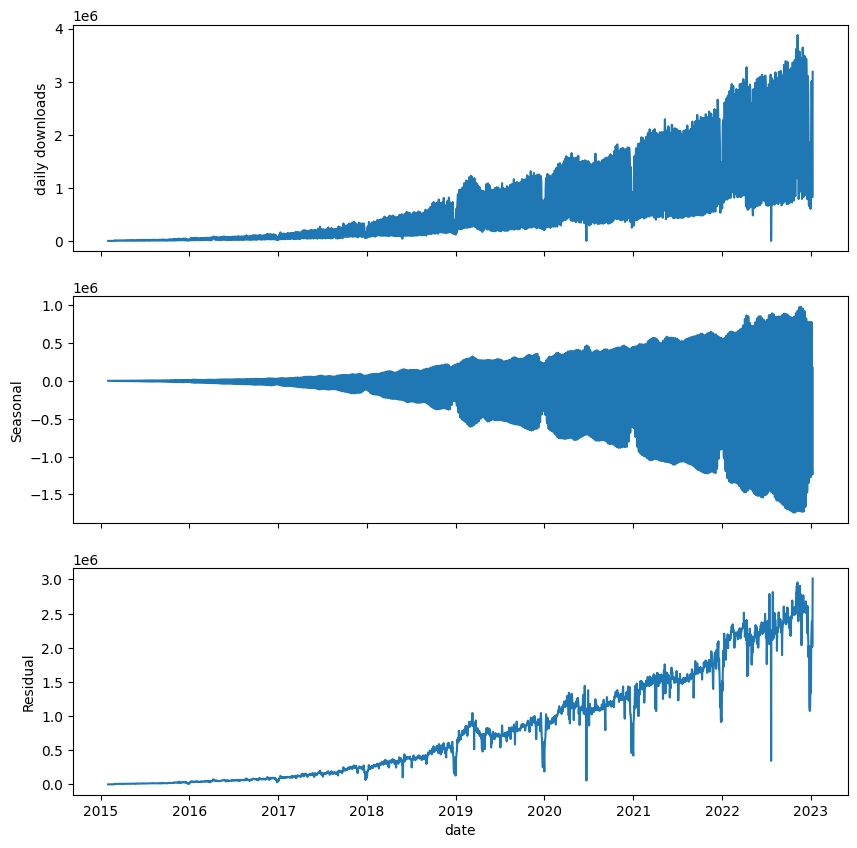

In [13]:
# seasonal_decomposition(counts, period) #bad period found automatically

# multiseasonal_decomposition(counts, [7, 365], 'daily_downloads')
trend, season, residual = seasonal_decomposition(counts, 7, 'daily downloads', dates, 'date')

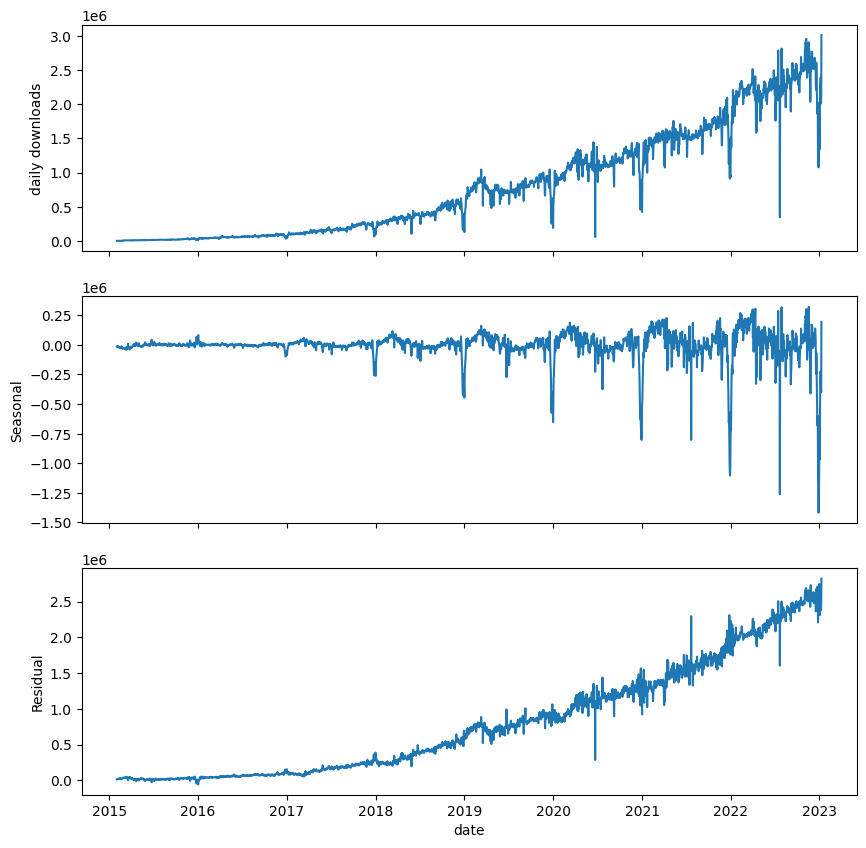

In [14]:
_ = seasonal_decomposition(trend + residual, 365, 'daily downloads', dates, 'date')

## Tides Height Example

In [15]:
df = pd.read_csv('Tide Prediction.csv')
df.head()

/home/david/anaconda3/envs/cartwright/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (1,2,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,time,longitude,latitude,stationID,Water_Level,Water_Level_ODM
0,UTC,degrees_east,degrees_north,NaN,metres,metres
1,2017-01-01T00:10:00Z,-10.101596,53.95219,Achill_Island_MODELLED,1.34,-1.23
2,2017-01-01T00:20:00Z,-10.101596,53.95219,Achill_Island_MODELLED,1.3,-1.27
3,2017-01-01T00:30:00Z,-10.101596,53.95219,Achill_Island_MODELLED,1.26,-1.31
4,2017-01-01T00:40:00Z,-10.101596,53.95219,Achill_Island_MODELLED,1.23,-1.34


In [16]:
print(df['stationID'].unique())
print(df.columns)

[nan 'Achill_Island_MODELLED' 'Aranmore' 'Arklow_MODELLED' 'Ballycotton'
 'Ballyglass' 'Bray_Harbour_MODELLED' 'Carrigaholt_MODELLED'
 'Castletownbere' 'Clare_Island_MODELLED' 'Crosshaven_MODELLED'
 'Dingle_Harbour_MODELLED' 'Dublin_Port' 'Dundalk' 'Dungarvan_MODELLED'
 'Dunmore_East' 'Fenit_MODELLED' 'Galway_Port' 'Howth' 'Inishmore'
 'Killary_Harbour_MODELLED' 'Killybegs' 'Kinsale_MODELLED'
 'Kish_Bank_Lighthouse' 'Lahinch_MODELLED' 'Letterfrack_MODELLED'
 'Malin_Head' 'Rosslare_Port_MODELLED' 'Skerries' 'Sligo'
 'Tory_Island_MODELLED' 'Union_Hall_MODELLED' 'Wexford' 'Wicklow_MODELLED']
Index(['time', 'longitude', 'latitude', 'stationID', 'Water_Level',
       'Water_Level_ODM'],
      dtype='object')


In [17]:
heights_df = df.loc[df['stationID'] == 'Aranmore', ['time', 'Water_Level']]
heights_df['time'] = pd.to_datetime(heights_df['time'])
heights_df.head()

,time,Water_Level
157682,2017-01-01 00:00:00+00:00,1.33
157683,2017-01-01 00:06:00+00:00,1.29
157684,2017-01-01 00:12:00+00:00,1.25
157685,2017-01-01 00:18:00+00:00,1.22
157686,2017-01-01 00:24:00+00:00,1.19


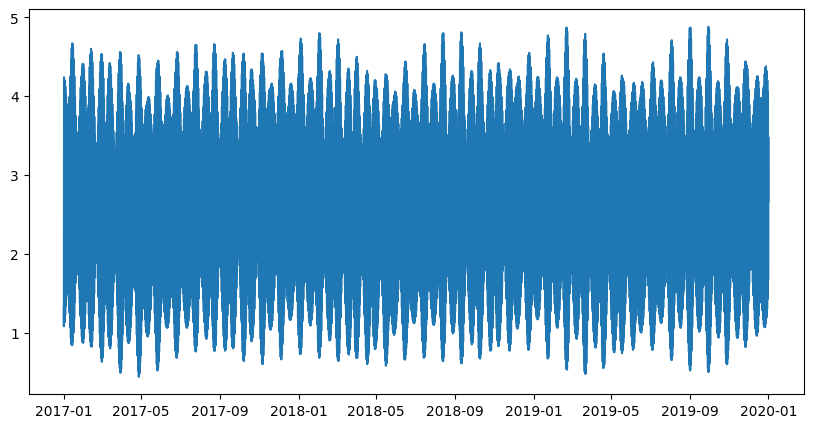

In [18]:
plt.figure(figsize=(10,5))
plt.plot(heights_df['time'],heights_df['Water_Level'])
plt.show()

In [19]:
# save the dates for the x axis later
dates = heights_df['time'].to_numpy()

#detect resolution of times

times = (heights_df['time'] - pd.Timestamp("1970-01-01T00:00:00Z")) // pd.Timedelta('1s')
tr = time_resolution.detect_temporal_resolution(times)

dt = tr.unit * tr.resolution #in seconds
print(f'time resolution is {dt/60:.02f} minutes')

time resolution is 6.00 minutes


[1.33 1.29 1.25 ... 2.78 2.73 2.67] (262801,)
possible cyclicality with period of 7729 samples


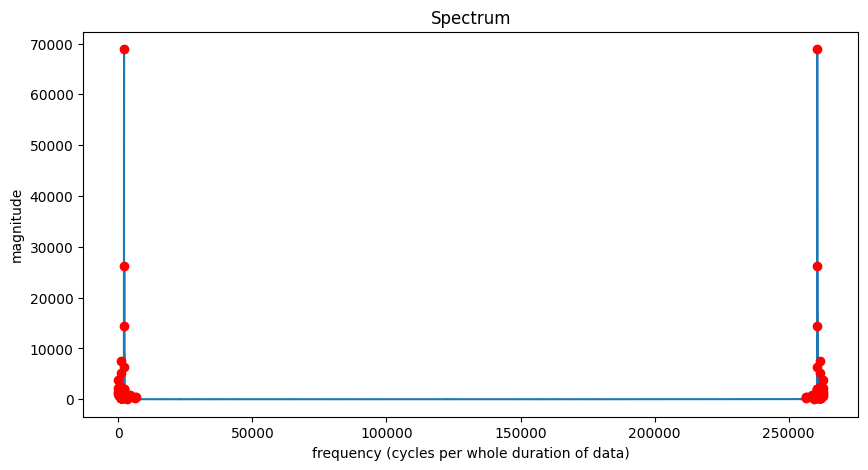

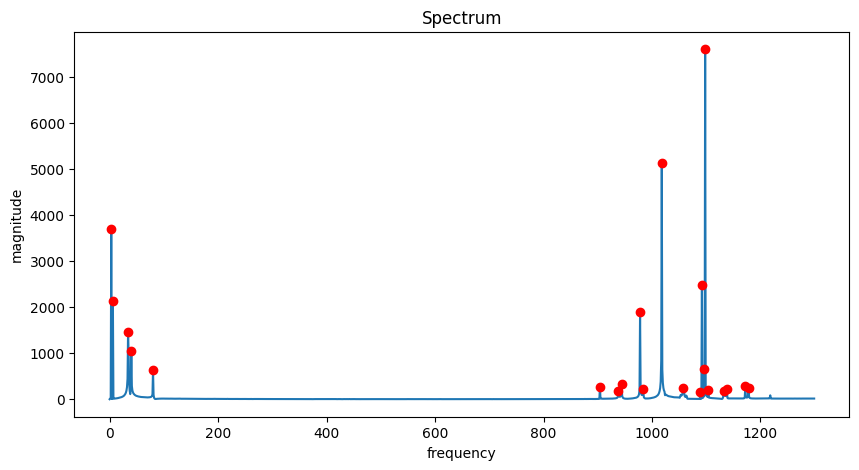

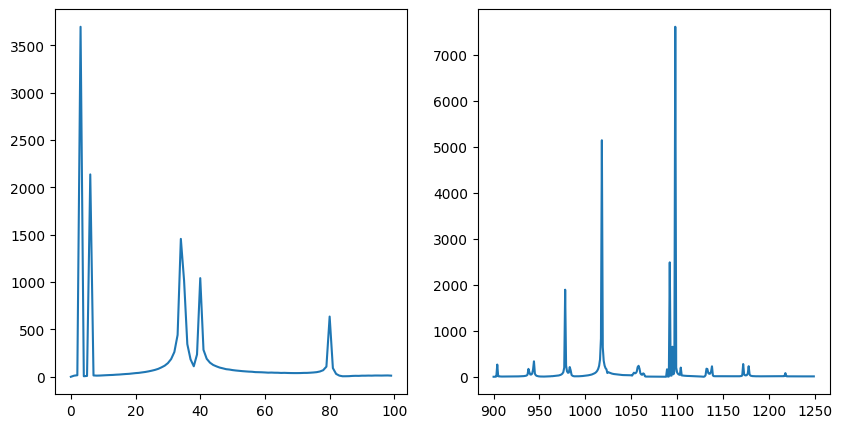

In [20]:
#do seasonality analysis
heights = heights_df['Water_Level'].to_numpy()
heights = heights.astype(float)
print(heights, heights.shape)
period = get_candidate_frequency(heights, prominence=100)



# so we can actually see the points better!
y = heights
norm_y = (y - np.mean(y)) / (np.max(y) - np.min(y)) * 2
z = np.abs(fft(norm_y))
freqs = np.fft.fftfreq(len(z))


#reduce size of z
z = z[:1300]
peaks, _ = find_peaks(z, prominence=100)

plt.figure(figsize=(10,5))
plt.plot(z)
plt.plot(peaks, z[peaks], "ro")
plt.title('Spectrum')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.show()



fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
axes[0].plot(np.arange(100),z[:100])
axes[1].plot(np.arange(900,1250),z[900:1250])
plt.show()


In [21]:
print(f'cycle is {period * dt / 60 / 60 / 24:.05f} days')
peaks
1/freqs[peaks]

cycle is 32.20417 days


array([87600.33333333, 43800.16666667,  7729.44117647,  6570.025     ,
        3285.0125    ,   290.7090708 ,   280.17164179,   278.39088983,
         268.71267894,   267.34587996,   258.15422397,   248.39413989,
         241.32323232,   240.66025641,   240.00091324,   239.34517304,
         238.04438406,   232.15636042,   230.93233743,   224.23293515,
         223.09083192])

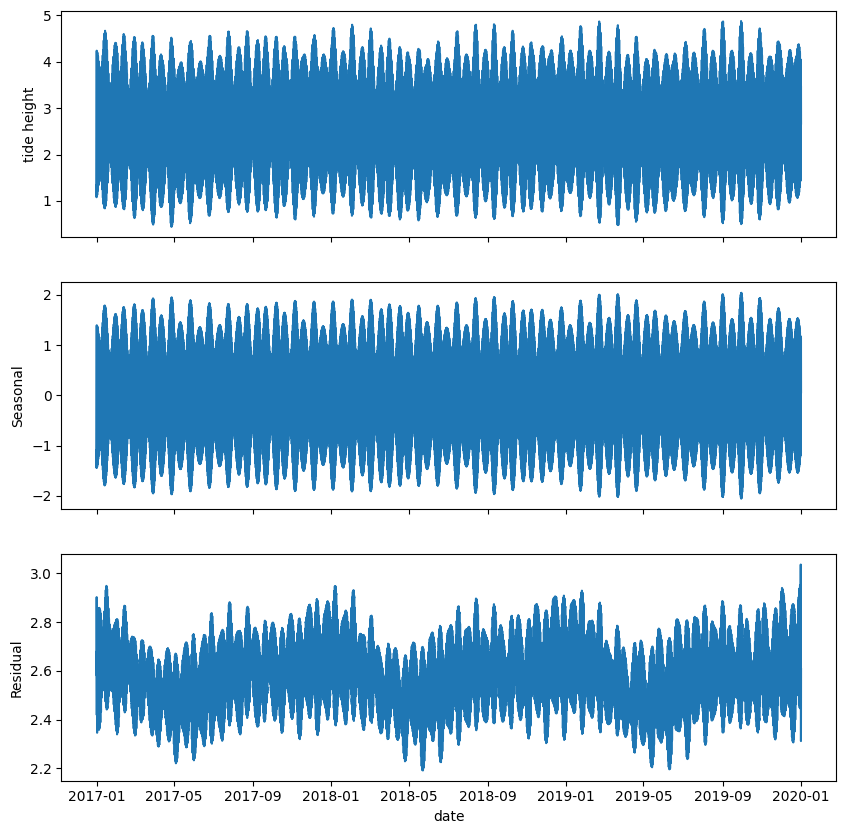

In [22]:
# y = heights[:10000] #STL takes too long
trend, season, residual = seasonal_decomposition(y, 122, 'tide height', dates, 'date')

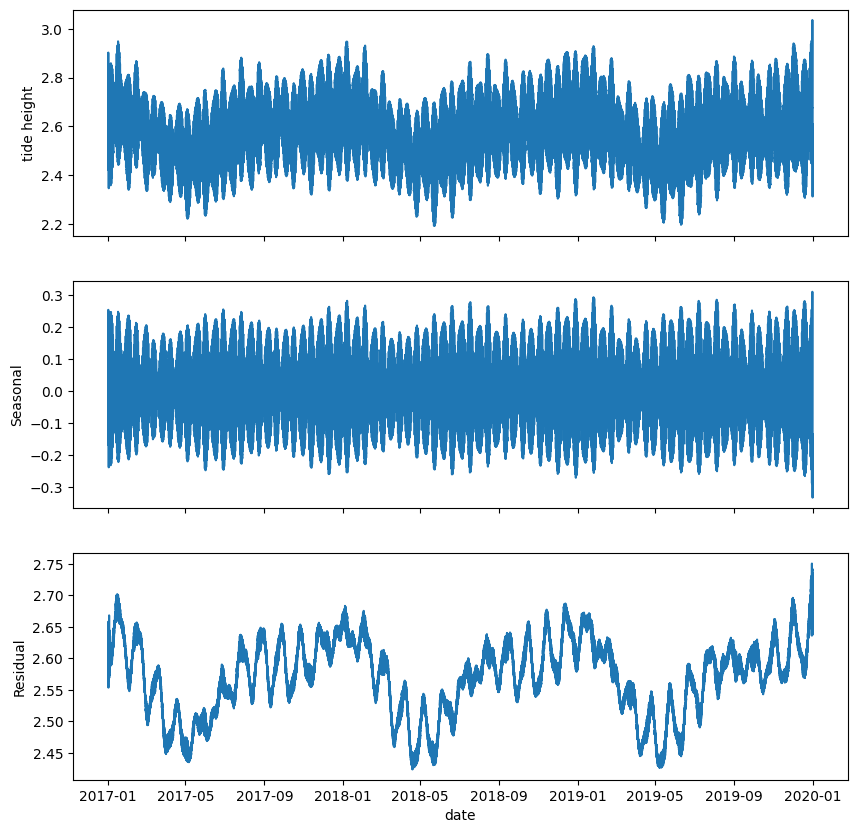

In [23]:
y = trend + residual
trend, season, residual = seasonal_decomposition(y, 247, 'tide height', dates, 'date')

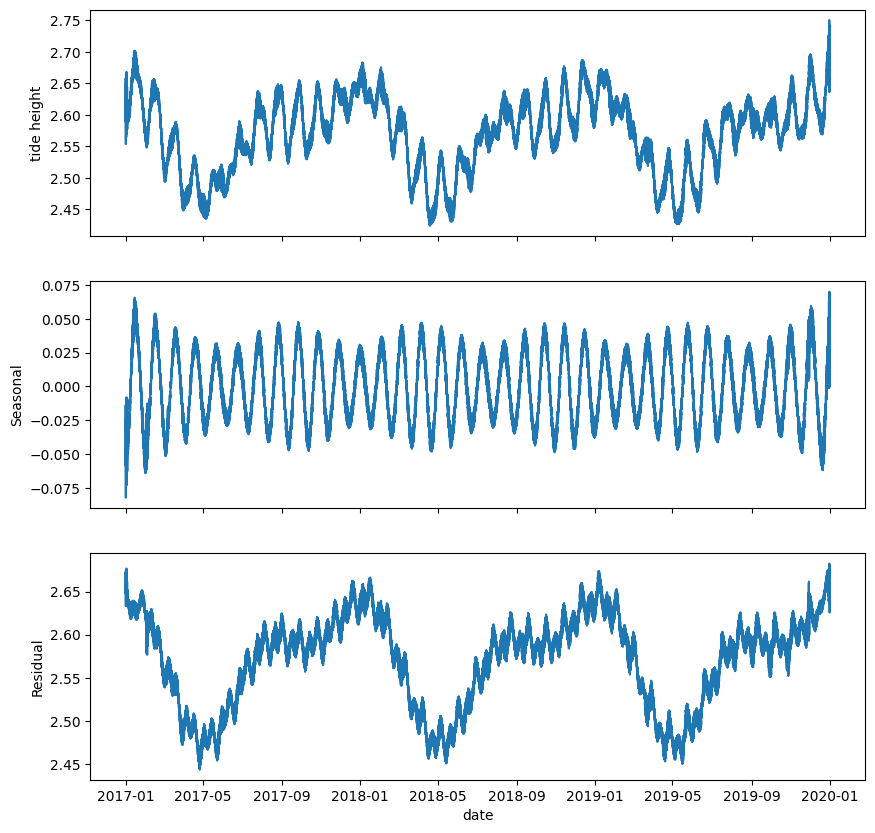

In [24]:
y = trend + residual
trend, season, residual = seasonal_decomposition(y, 7729, 'tide height', dates, 'date')

# Conclusion
- All the seasonality decomposition libraries evaluated require the period to be known beforehand. This creates a requirment for some sort of automatic frequency detection process.
- automatically detecting frequencies is hard. In this experiment, lots of fine tuning was required to get the FFT method to perform well. E.g. for finding peaks, the prominence parameter needed to be set to a sensible value by examining the spectrum plot. There are tons and tons of different approaches, some of which may be good, though historically I've had a hard time finding good ready-made solutions.
  - Normalized auto-correlation
  - FFT approaches
  - wavelet approaches
  - dynamic time warping approaches
  - machine learning approaches
  - etc.
- For the tidal data, the FFT method did not really work at all, so each filter step was performed with manually selected
- an interesting observation is that the seasonality decomposition libraries seem to prefer the highest frequencies be handled first, then followed by lower frequencies. This is somewhat counter to most frequency/pitch detection processes since at higher frequencies, harmonics are sometimes hard to distinguish from fundamental frequencies.
- for performing the filtering, the `LOESS` algorithm from `statsmodel` performs decently well when the target frequency is known. It would be interesting to compare its performance to standard band-stop filters from the signals processing domain, which may be more flexible
- if you feed an incorrect frequency into `LOESS` to be filtered, the resulting data can be mangled, and there's not an easy way to tell if this occurred, or if the supplied frequency was actually present in the data.
- `LOESS` is very slow on long datasets. e.g. the third filtering step above on the tidal data takes over 20 minutes